In [2]:
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import seaborn as sns
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterstats import point_query
from rasterio.features import geometry_mask



In [3]:
# Define file path and canopy height threshold
file_path = r"C:\Users\bsf31\Documents\post-meds\data\signal\climate\NM\meta\mod_nodata\canopy_height_hurley_2023.tif"
canopy_threshold = 2  # Minimum height in meters for a pixel to be considered canopy

In [4]:
src_file = r"C:\Users\bsf31\Documents\post-meds\data\signal\climate\NM\meta\mod_nodata\canopy_height_hurley_2023.tif"
dst_file = r"C:\Users\bsf31\Documents\post-meds\data\signal\climate\NM\meta\mod_nodata\canopy_height_hurley_2023_reprojected.tif"
dst_crs = 'EPSG:32612'  # UTM Zone 12N 


In [5]:
""" # Reproject the raster
with rasterio.open(src_file) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(dst_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

print("Reprojection complete.") """

' # Reproject the raster\nwith rasterio.open(src_file) as src:\n    transform, width, height = calculate_default_transform(\n        src.crs, dst_crs, src.width, src.height, *src.bounds)\n    kwargs = src.meta.copy()\n    kwargs.update({\n        \'crs\': dst_crs,\n        \'transform\': transform,\n        \'width\': width,\n        \'height\': height\n    })\n\n    with rasterio.open(dst_file, \'w\', **kwargs) as dst:\n        for i in range(1, src.count + 1):\n            reproject(\n                source=rasterio.band(src, i),\n                destination=rasterio.band(dst, i),\n                src_transform=src.transform,\n                src_crs=src.crs,\n                dst_transform=transform,\n                dst_crs=dst_crs,\n                resampling=Resampling.nearest)\n\nprint("Reprojection complete.") '

In [6]:
# Open the raster file
with rasterio.open(dst_file) as src:
    canopy_data = src.read(1)  # Read the first band
    pixel_area = src.res[0] * src.res[1]  # Area of each pixel in square meters

In [7]:
pixel_area

0.9684324550357623

In [8]:
with rasterio.open(dst_file) as src:
    print("Resolution:", src.res)

Resolution: (0.9840896580270327, 0.9840896580270327)


In [9]:
# Mask canopy pixels above threshold
canopy_mask = canopy_data > canopy_threshold

In [10]:
# Calculate the total area of canopy cover
canopy_area = np.sum(canopy_mask) * pixel_area  # Area in square meters
canopy_area_hectares = canopy_area / 10000  # Convert to hectares

In [11]:
canopy_heights = canopy_data[canopy_mask]  # Extract heights where canopy exists
mean_height = np.mean(canopy_heights)
median_height = np.median(canopy_heights)
min_height = np.min(canopy_heights)
max_height = np.max(canopy_heights)
std_dev_height = np.std(canopy_heights)

In [12]:
print(f"Total Canopy Area: {canopy_area:.2f} square meters ({canopy_area_hectares:.2f} hectares)")
print("Canopy Height Statistics:")
print(f"Mean Height: {mean_height:.2f} meters")
print(f"Median Height: {median_height:.2f} meters")
print(f"Minimum Height: {min_height:.2f} meters")
print(f"Maximum Height: {max_height:.2f} meters")
print(f"Standard Deviation of Height: {std_dev_height:.2f} meters")

Total Canopy Area: 94046.41 square meters (9.40 hectares)
Canopy Height Statistics:
Mean Height: 5.41 meters
Median Height: 5.00 meters
Minimum Height: 3.00 meters
Maximum Height: 22.00 meters
Standard Deviation of Height: 2.47 meters


In [13]:
nm_path = r"C:\Users\bsf31\Documents\post-meds\data\signal\climate\NM\nm_vector.gpkg"
hurley_gdf = gpd.read_file(nm_path, layer='hurley')

In [14]:
hurley_gdf

,GEOID,place,state,state_abbr,county,ua_name,ua_pop,congressio,cbg_pop,acs_pop,...,health_nor,temp_diff,temp_norm,tes,tesctyscor,holc_grade,child_perc,seniorperc,temp_name,geometry
0,350179648001,Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,584,954.0,...,0.261476,0.89,0.667350,87,87.0,None,0.330189,0.212788,East-South,"MULTIPOLYGON (((768777.31 3622536.394, 768747...."
1,350179646001,North Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,288,650.0,...,0.336909,1.70,0.691069,90,90.0,None,0.040000,0.436923,North Hurley,"MULTIPOLYGON (((768701.113 3624255.967, 768711..."


In [15]:
def canopy_area(arr, mask):
    # Use np.isfinite to ensure no nodata values in the calculation
    valid_data = np.isfinite(arr) & (arr > canopy_threshold)
    return np.sum(valid_data) * pixel_area

In [16]:
# Calculate zonal statistics for each polygon in hurley_gdf
stats = zonal_stats(
    hurley_gdf,
    dst_file,
    stats=["mean", "median", "min", "max", "std"],
    add_stats={'area': canopy_area},
    prefix="canopy_"
)

In [17]:
stats

[{'canopy_min': 1.0,
  'canopy_max': 22.0,
  'canopy_mean': 3.5083777072346525,
  'canopy_std': 2.7987388010562,
  'canopy_median': 3.0,
  'canopy_area': np.float64(77707.02019206957)},
 {'canopy_min': 1.0,
  'canopy_max': 15.0,
  'canopy_mean': 3.009546402949667,
  'canopy_std': 2.1658900878309866,
  'canopy_median': 2.0,
  'canopy_area': np.float64(16239.643838494698)}]

In [18]:
zonal_df = pd.DataFrame(stats)



In [19]:
zonal_df

,canopy_min,canopy_max,canopy_mean,canopy_std,canopy_median,canopy_area
0,1.0,22.0,3.508378,2.798739,3.0,77707.020192
1,1.0,15.0,3.009546,2.165890,2.0,16239.643838


In [20]:
hurley_gdf = hurley_gdf.join(zonal_df)


In [21]:
hurley_gdf

,GEOID,place,state,state_abbr,county,ua_name,ua_pop,congressio,cbg_pop,acs_pop,...,child_perc,seniorperc,temp_name,geometry,canopy_min,canopy_max,canopy_mean,canopy_std,canopy_median,canopy_area
0,350179648001,Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,584,954.0,...,0.330189,0.212788,East-South,"MULTIPOLYGON (((768777.31 3622536.394, 768747....",1.0,22.0,3.508378,2.798739,3.0,77707.020192
1,350179646001,North Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,288,650.0,...,0.040000,0.436923,North Hurley,"MULTIPOLYGON (((768701.113 3624255.967, 768711...",1.0,15.0,3.009546,2.165890,2.0,16239.643838


In [22]:
# Group by 'temp_name' to get aggregated canopy statistics
grouped_stats = hurley_gdf.groupby("place").agg({
    'canopy_mean': 'mean',
    'canopy_median': 'mean',
    'canopy_min': 'min',
    'canopy_max': 'max',
    'canopy_std': 'mean',
    'canopy_area': 'sum'
}).reset_index()

In [23]:
print(grouped_stats)

          place  canopy_mean  canopy_median  canopy_min  canopy_max  \
0        Hurley     3.508378            3.0         1.0        22.0   
1  North Hurley     3.009546            2.0         1.0        15.0   

   canopy_std   canopy_area  
0    2.798739  77707.020192  
1    2.165890  16239.643838  


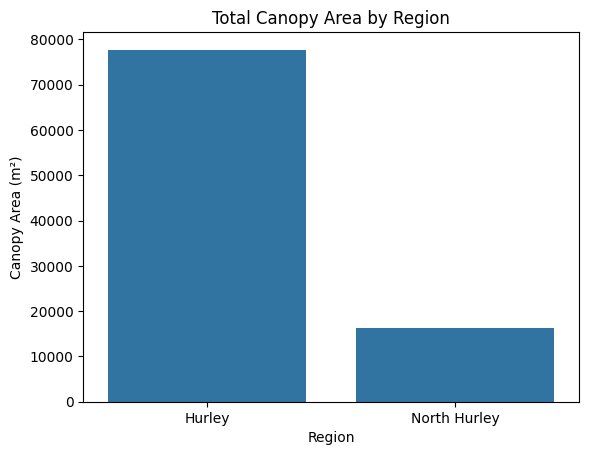

In [24]:
sns.barplot(x='place', y='canopy_area', data=grouped_stats)
plt.title('Total Canopy Area by Region')
plt.xlabel('Region')
plt.ylabel('Canopy Area (m²)')
plt.show()

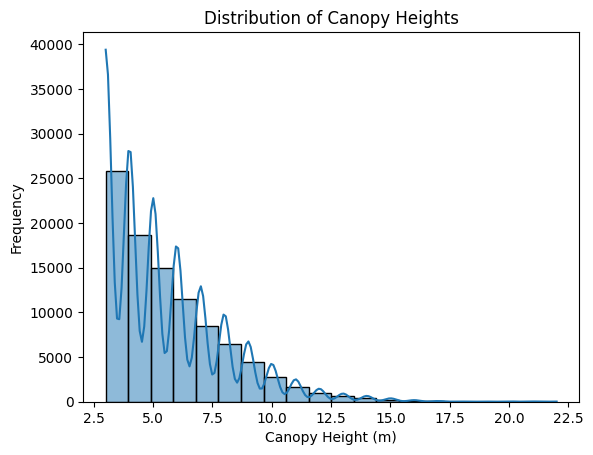

In [25]:
sns.histplot(canopy_heights, bins=20, kde=True)
plt.title('Distribution of Canopy Heights')
plt.xlabel('Canopy Height (m)')
plt.ylabel('Frequency')
plt.show()


In [26]:
# %% Calculate total area for Hurley and North Hurley
hurley_gdf['total_area'] = hurley_gdf.geometry.area  # Area in square meters
total_area_hurley = hurley_gdf.loc[hurley_gdf['place'] == 'Hurley', 'total_area'].sum()
total_area_north_hurley = hurley_gdf.loc[hurley_gdf['place'] == 'North Hurley', 'total_area'].sum()

# %% Canopy Cover Percent for Each Region
hurley_gdf['canopy_cover_percent'] = (hurley_gdf['canopy_area'] / hurley_gdf['total_area']) * 100
hurley_gdf

,GEOID,place,state,state_abbr,county,ua_name,ua_pop,congressio,cbg_pop,acs_pop,...,temp_name,geometry,canopy_min,canopy_max,canopy_mean,canopy_std,canopy_median,canopy_area,total_area,canopy_cover_percent
0,350179648001,Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,584,954.0,...,East-South,"MULTIPOLYGON (((768777.31 3622536.394, 768747....",1.0,22.0,3.508378,2.798739,3.0,77707.020192,1.876396e+06,4.141292
1,350179646001,North Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,288,650.0,...,North Hurley,"MULTIPOLYGON (((768701.113 3624255.967, 768711...",1.0,15.0,3.009546,2.165890,2.0,16239.643838,3.859084e+05,4.208160


place	        _count	_sum	_mean	            _stdev	            _min	_max	_range
Hurley	        156248	548177	3.5083777072346525	2.798738801054911	1	    22	    21
North Hurley	34987	105295	3.009546402949667	2.165890087831071	1	    15	    14

temp_name	_count	_mean	_min	_max	_range
East-South	87160	3.509591556	1	22	21
Central	93217	3.50624886	1	16	15
North Hurley	40343	3.010063704	1	15	14


In [27]:
data = {
    "Region": ["Hurley", "North Hurley"],
    "Pixel_Count": [156248, 34987],
    "Mean_Height": [3.51, 3.01],
    "Min_Height": [1, 1],
    "Max_Height": [22, 15],
    "Range": [21, 14]
}

# Convert data to DataFrame
df = pd.DataFrame(data)

# Calculate canopy area by region (assuming 1m^2 per pixel)
df['Canopy_Area_m2'] = df['Pixel_Count'] * 1  # each pixel represents 1m^2


In [28]:
# Total canopy area
total_canopy_area = df['Canopy_Area_m2'].sum()

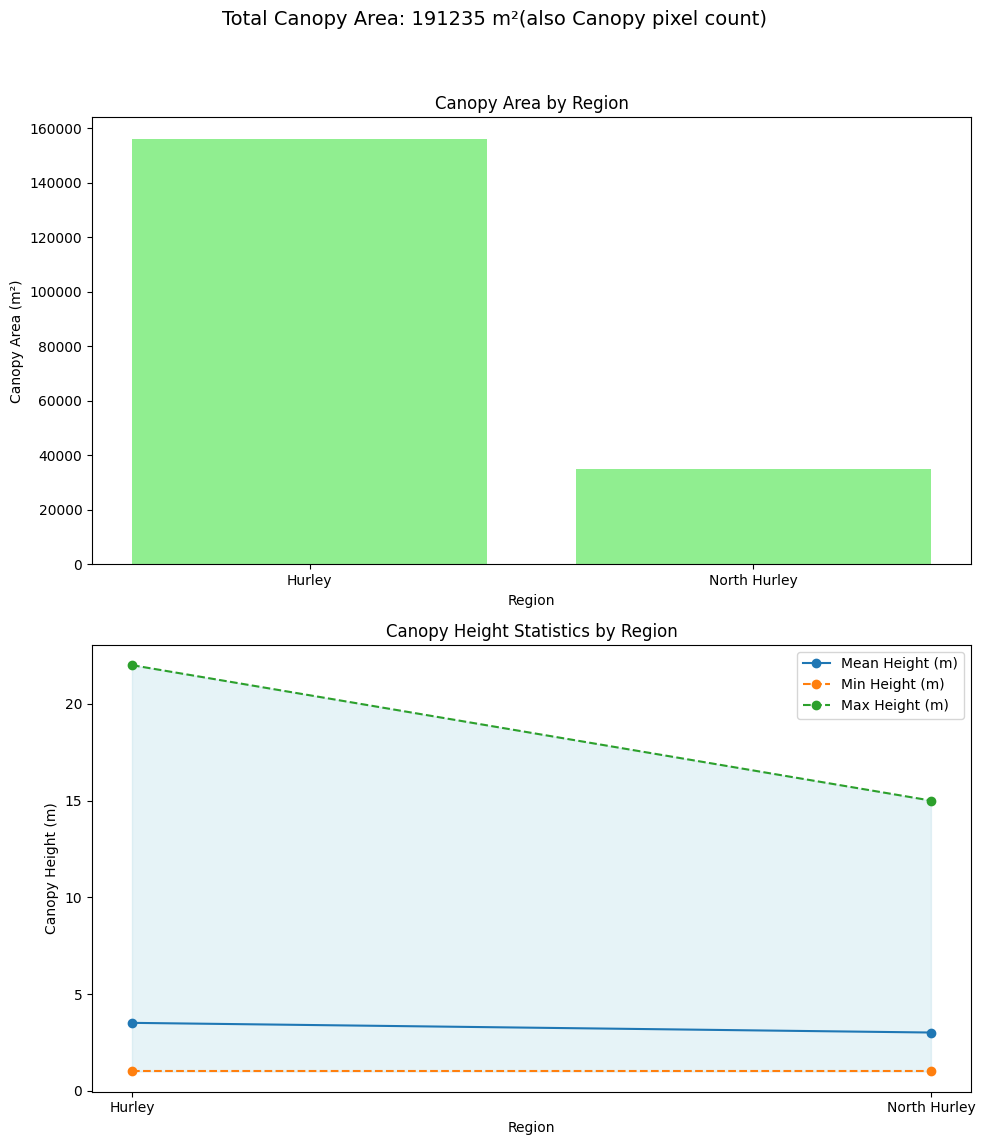

In [32]:
# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Bar chart for canopy area by region
ax[0].bar(df["Region"], df["Canopy_Area_m2"], color='lightgreen')
ax[0].set_title("Canopy Area by Region")
ax[0].set_ylabel("Canopy Area (m²)")
ax[0].set_xlabel("Region")
# Line plot for canopy height stats by region
ax[1].plot(df["Region"], df["Mean_Height"], marker='o', label='Mean Height (m)')
ax[1].plot(df["Region"], df["Min_Height"], marker='o', linestyle='--', label='Min Height (m)')
ax[1].plot(df["Region"], df["Max_Height"], marker='o', linestyle='--', label='Max Height (m)')
ax[1].fill_between(df["Region"], df["Min_Height"], df["Max_Height"], color='lightblue', alpha=0.3)
ax[1].set_title("Canopy Height Statistics by Region")
ax[1].set_ylabel("Canopy Height (m)")
ax[1].set_xlabel("Region")
ax[1].legend()

# Display the total canopy area on the plot
fig.suptitle(f"Total Canopy Area: {total_canopy_area} m²(also Canopy pixel count)", fontsize=14)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [33]:
# %% Calculate total area for Hurley and North Hurley
hurley_gdf['total_area'] = hurley_gdf.geometry.area  # Area in square meters
total_area_hurley = hurley_gdf.loc[hurley_gdf['temp_name'] == 'Hurley', 'total_area'].sum()
total_area_north_hurley = hurley_gdf.loc[hurley_gdf['temp_name'] == 'North Hurley', 'total_area'].sum()

# %% Canopy Cover Percent for Each Region
hurley_gdf['canopy_cover_percent'] = (hurley_gdf['canopy_area'] / hurley_gdf['total_area']) * 100


In [38]:
hurley_gdf

,GEOID,place,state,state_abbr,county,ua_name,ua_pop,congressio,cbg_pop,acs_pop,...,overstory_area,overstory_percent,understory_area,understory_percent,overstory_area,overstory_percent,understory_area,understory_percent,overstory_area,overstory_percent
0,350179648001,Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,584,954.0,...,77707.020192,4.141298,26653.198027,1.420449,77707.020192,4.141298,26653.198027,1.420449,77707.020192,4.141298
1,350179646001,North Hurley,New Mexico,NM,Grant County,"Bayard, NM",4966,NM Congressional District 2,288,650.0,...,16239.643838,4.208664,6653.130966,1.724224,16239.643838,4.208664,6653.130966,1.724224,16239.643838,4.208664


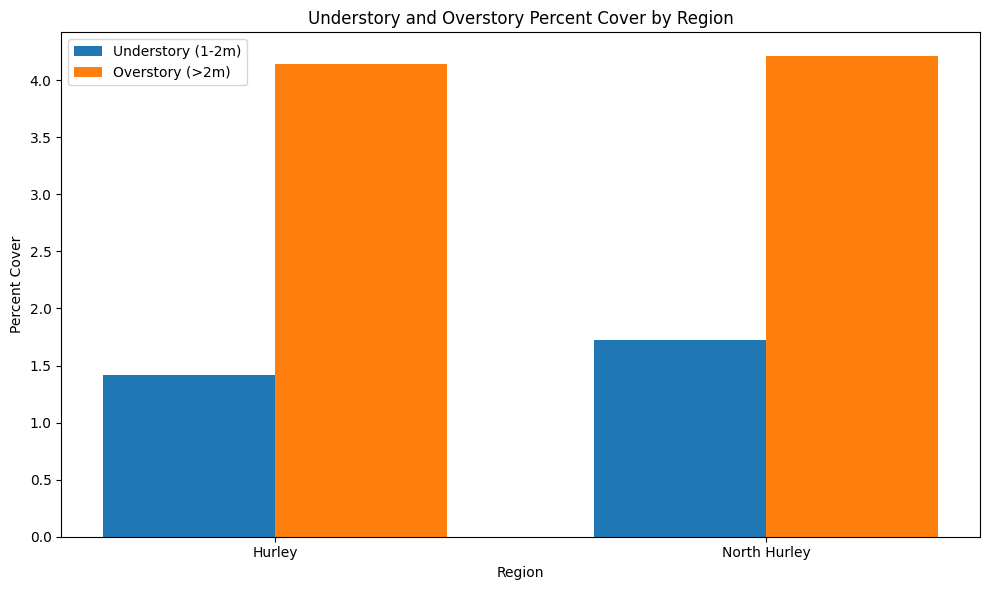

          place  canopy_cover_percent  understory_area  overstory_area  \
0        Hurley              5.561739     26653.198027    77707.020192   
1  North Hurley              5.932178      6653.130966    16239.643838   

   understory_percent  overstory_percent  
0            1.420449           4.141298  
1            1.724224           4.208664  


In [29]:

# %% Helper Function for Understory and Overstory Stats
def calculate_region_understory_overstory_stats(geometry, canopy_raster, mask, transform, pixel_area):
    """Calculate understory and overstory stats for a specific polygon region."""
    # Create a mask for the region
    region_mask = geometry_mask([geometry], transform=transform, invert=True, out_shape=canopy_raster.shape)
    combined_mask = region_mask & mask

    # Separate understory (1-3m) and overstory (>3m)
    understory_mask = (canopy_raster > 1) & (canopy_raster <= 2) & combined_mask
    overstory_mask = (canopy_raster > 2) & combined_mask

    # Calculate areas
    understory_area = np.sum(understory_mask) * pixel_area
    overstory_area = np.sum(overstory_mask) * pixel_area

    # Region total area
    region_area = np.sum(region_mask) * pixel_area

    # Percentages
    understory_percent = (understory_area / region_area) * 100 if region_area > 0 else 0
    overstory_percent = (overstory_area / region_area) * 100 if region_area > 0 else 0

    return {
        'understory_area': understory_area,
        'understory_percent': understory_percent,
        'overstory_area': overstory_area,
        'overstory_percent': overstory_percent
    }

# %% Load Data
with rasterio.open(dst_file) as src:
    canopy_data = src.read(1)
    transform = src.transform
    pixel_area = src.res[0] * src.res[1]
    canopy_mask = canopy_data > 0  # Assume canopy mask is non-zero values

# %% Apply Stats Calculation to Each Region
stats = []
for _, row in hurley_gdf.iterrows():
    stats.append(calculate_region_understory_overstory_stats(
        row.geometry, canopy_data, canopy_mask, transform, pixel_area))

# Merge stats into GeoDataFrame
stats_df = pd.DataFrame(stats)
hurley_gdf = pd.concat([hurley_gdf, stats_df], axis=1)

# %% Calculate Total Canopy Cover Percent
hurley_gdf['canopy_cover_percent'] = (
    (hurley_gdf['understory_area'] + hurley_gdf['overstory_area']) / hurley_gdf['total_area']) * 100

# %% Summarize by Region
summary_stats = hurley_gdf.groupby('place').agg({
    'canopy_cover_percent': 'mean',
    'understory_area': 'sum',
    'overstory_area': 'sum',
    'understory_percent': 'mean',
    'overstory_percent': 'mean'
}).reset_index()

# %% Visualization: Understory and Overstory Percent Cover
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(summary_stats))

ax.bar(index, summary_stats['understory_percent'], bar_width, label='Understory (1-2m)')
ax.bar(index + bar_width, summary_stats['overstory_percent'], bar_width, label='Overstory (>2m)')

ax.set_title('Understory and Overstory Percent Cover by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Percent Cover')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(summary_stats['place'])
ax.legend()

plt.tight_layout()
plt.show()

# %% Print Summary
print(summary_stats)


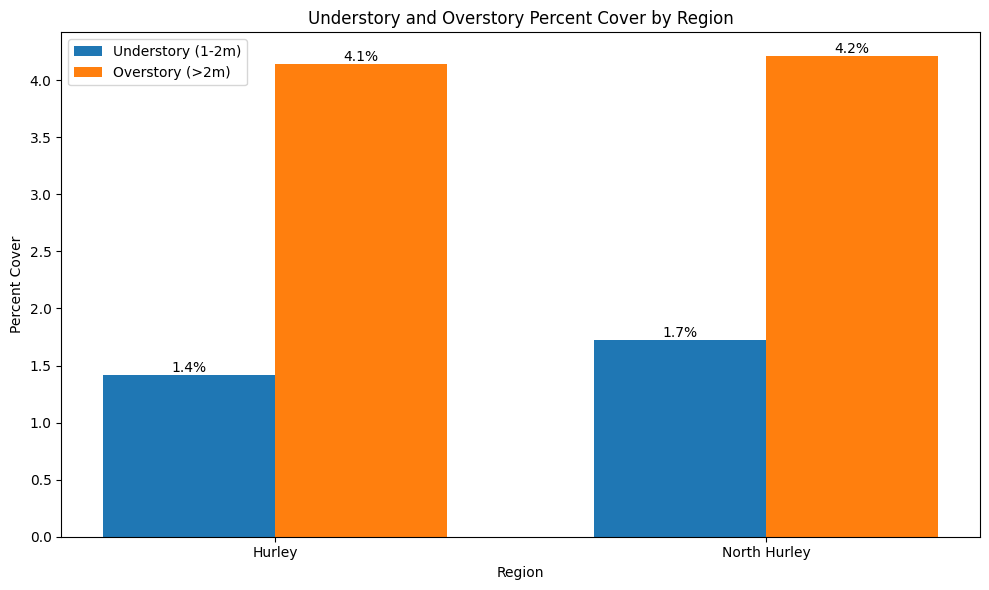

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(summary_stats))

# Create the bars
understory_bars = ax.bar(index, summary_stats['understory_percent'], bar_width, label='Understory (1-2m)')
overstory_bars = ax.bar(index + bar_width, summary_stats['overstory_percent'], bar_width, label='Overstory (>2m)')

# Add annotations
for bar in understory_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,  # Position text at center of the bar
        f"{height:.1f}%",  # Format the text
        ha='center', va='bottom', fontsize=10  # Alignment and font size
    )

for bar in overstory_bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height,
        f"{height:.1f}%",
        ha='center', va='bottom', fontsize=10
    )

# Set plot labels and title
ax.set_title('Understory and Overstory Percent Cover by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Percent Cover')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(summary_stats['place'])
ax.legend()

plt.tight_layout()
plt.show()


In [32]:
# %% Print Summary
print(summary_stats)

          place  canopy_cover_percent  understory_area  overstory_area  \
0        Hurley              5.561739     26653.198027    77707.020192   
1  North Hurley              5.932178      6653.130966    16239.643838   

   understory_percent  overstory_percent  
0            1.420449           4.141298  
1            1.724224           4.208664  


In [34]:
# %% Separate Understory (1-3 meters) and Overstory (>3 meters)
def calculate_understory_overstory_stats(raster, mask):
    understory_mask = (raster > 1) & (raster <= 3) & mask
    overstory_mask = (raster > 3) & mask
    
    # Understory stats
    understory_area = np.sum(understory_mask) * pixel_area
    understory_mean = np.mean(raster[understory_mask]) if np.any(understory_mask) else 0
    
    # Overstory stats
    overstory_area = np.sum(overstory_mask) * pixel_area
    overstory_mean = np.mean(raster[overstory_mask]) if np.any(overstory_mask) else 0
    
    return {
        'understory_area': understory_area,
        'understory_mean': understory_mean,
        'overstory_area': overstory_area,
        'overstory_mean': overstory_mean
    }

In [35]:

# Apply function to the entire raster
stats_by_layer = calculate_understory_overstory_stats(canopy_data, canopy_mask)

In [36]:
# %% Calculate Understory and Overstory Stats for Each Polygon
def calculate_region_understory_overstory_stats(geometry, canopy_raster, mask, transform):
    """Calculate understory and overstory stats for a specific polygon region."""
    # Mask the raster by the geometry
    region_mask = rasterio.features.geometry_mask(
        [geometry], transform=transform, invert=True, out_shape=canopy_raster.shape)
    
    combined_mask = region_mask & mask  # Combine with canopy mask
    
    # Separate understory and overstory
    understory_mask = (canopy_raster > 1) & (canopy_raster <= 3) & combined_mask
    overstory_mask = (canopy_raster > 3) & combined_mask
    
    # Calculate areas
    understory_area = np.sum(understory_mask) * pixel_area
    overstory_area = np.sum(overstory_mask) * pixel_area
    
    # Percentages (relative to the region area)
    region_area = np.sum(region_mask) * pixel_area
    understory_percent = (understory_area / region_area) * 100 if region_area > 0 else 0
    overstory_percent = (overstory_area / region_area) * 100 if region_area > 0 else 0
    
    return {
        'understory_area': understory_area,
        'understory_percent': understory_percent,
        'overstory_area': overstory_area,
        'overstory_percent': overstory_percent
    }

# %% Apply Stats Calculation to Each Region in the GeoDataFrame
with rasterio.open(dst_file) as src:
    canopy_data = src.read(1)
    transform = src.transform

    stats = []
    for _, row in hurley_gdf.iterrows():
        stats.append(calculate_region_understory_overstory_stats(
            row.geometry, canopy_data, canopy_mask, transform))

# Convert stats to a DataFrame and merge with GeoDataFrame
stats_df = pd.DataFrame(stats)
hurley_gdf = pd.concat([hurley_gdf, stats_df], axis=1)

# %% Recalculate Canopy Cover Percent
hurley_gdf['canopy_cover_percent'] = (
    (hurley_gdf['understory_area'] + hurley_gdf['overstory_area']) / hurley_gdf['total_area']) * 100

# %% Group by Region and Summarize
summary_stats = hurley_gdf.groupby('temp_name').agg({
    'canopy_cover_percent': 'mean',
    'understory_area': 'sum',
    'overstory_area': 'sum',
    'understory_percent': 'mean',
    'overstory_percent': 'mean'
}).reset_index()

# %% Display Results
print(summary_stats)


ValueError: cannot reindex on an axis with duplicate labels

In [ ]:


# %% Visualization of Understory and Overstory
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(summary_stats))

ax.bar(index, summary_stats['understory_percent'], bar_width, label='Understory (1-3m)')
ax.bar(index + bar_width, summary_stats['overstory_percent'], bar_width, label='Overstory (>3m)')

ax.set_title('Understory and Overstory Percent Cover by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Percent Cover')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(summary_stats['temp_name'])
ax.legend()

plt.tight_layout()
plt.show()

# %% Summary Output
print(summary_stats)


C:\Users\bsf31\miniconda3

C:\Users\bsf31\miniconda3\Library\bin

C:\Users\bsf31\miniconda3\condabin

C:\Program Files\Microsoft VS Code\bin

# Terminal Environment Changes

## Extension: GitHub.copilot-chat

Enables use of the `copilot-debug` command in the terminal.

- `PATH=${env:PATH};c:\Users\bsf31\AppData\Roaming\Code\User\globalStorage\github.copilot-chat\debugCommand`

## Extension: vscode.git

Enables the following features: git auth provider

- `GIT_ASKPASS=c:\Program Files\Microsoft VS Code\resources\app\extensions\git\dist\askpass.sh`
- `VSCODE_GIT_ASKPASS_NODE=C:\Program Files\Microsoft VS Code\Code.exe`
- `VSCODE_GIT_ASKPASS_EXTRA_ARGS=`
- `VSCODE_GIT_ASKPASS_MAIN=c:\Program Files\Microsoft VS Code\resources\app\extensions\git\dist\askpass-main.js`
- `VSCODE_GIT_IPC_HANDLE=\\.\pipe\vscode-git-6a112b088f-sock`

## Extension: ms-python.python

Activated environment for `~\miniconda3\python.exe`

- `CONDA_DEFAULT_ENV=base`
- `CONDA_EXE=C:/Users/bsf31/miniconda3/Scripts/conda.exe`
- `CONDA_PREFIX=C:\Users\bsf31\miniconda3`
- `CONDA_PROMPT_MODIFIER=(base) `
- `CONDA_PYTHON_EXE=C:/Users/bsf31/miniconda3/python.exe`
- `CONDA_SHLVL=1`
- `EXEPATH=C:\Program Files\Git\bin`
- `HOME=C:\Users\bsf31`
- `MSYSTEM=MINGW64`
- `PATH=C:\Users\bsf31\miniconda3;C:\Users\bsf31\miniconda3\Library\mingw-w64\bin;C:\Users\bsf31\miniconda3\Library\usr\bin;C:\Users\bsf31\miniconda3\Library\bin;C:\Users\bsf31\miniconda3\Scripts;C:\Users\bsf31\miniconda3\bin;C:\Users\bsf31\miniconda3\condabin;C:\Program Files\Git\mingw64\bin;C:\Program Files\Git\usr\bin;C:\Users\bsf31\bin;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\dotnet;C:\Program Files\Git\cmd;C:\Program Files\NVIDIA Corporation\NVIDIA app\NvDLISR;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;C:\Users\bsf31\.cargo\bin;C:\Users\bsf31\AppData\Local\Microsoft\WindowsApps;${env:PATH}`
- `PLINK_PROTOCOL=ssh`
- `PWD=C:/Program Files/Microsoft VS Code`
- `PYTHONIOENCODING=utf-8`
- `PYTHONUNBUFFERED=1`
- `SSL_CERT_FILE=C:\Users\bsf31\miniconda3\Library\ssl\cacert.pem`
- `TERM=xterm-256color`
- `_CE_CONDA=`
- `_CE_M=`
- `__CONDA_OPENSLL_CERT_FILE_SET=1`